In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Make matplotlib plots bigger
plt.rcParams['figure.figsize'] = [15, 9]

Original image shape: (3133, 3133, 3)
Original image dtype: float64


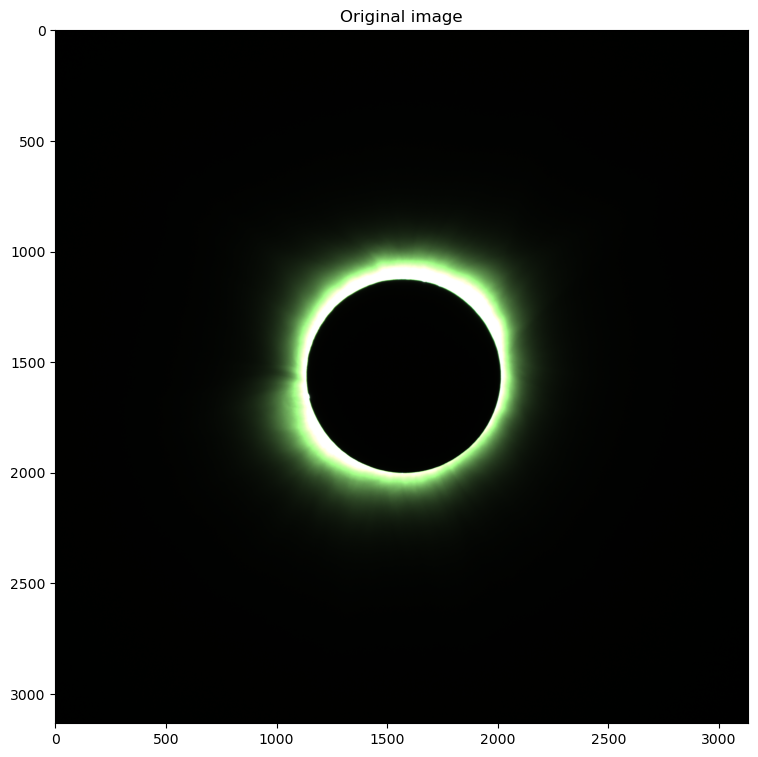

In [2]:
orig_image = cv2.imread('images/eclipse_square.tif', flags=cv2.IMREAD_UNCHANGED | cv2.IMREAD_IGNORE_ORIENTATION) / (2**16 - 1)
print('Original image shape:', orig_image.shape)
print('Original image dtype:', orig_image.dtype)

plt.imshow(orig_image, vmin=0.0, vmax=1.0)
_ = plt.title('Original image')

In [3]:
# We want to create a test image by transforming the original image.
def transform_image(image, translate_x, translate_y, scale, rotation_degrees):
    translation_matrix = np.array([[1, 0, translate_x],
                                [0, 1, translate_y],
                                [0, 0, 1]], dtype=np.float32)

    # Create rotation matrix around center with scaling
    rotate_scale_matrix = np.vstack((
        cv2.getRotationMatrix2D(
            center=(image.shape[1] // 2, image.shape[0] // 2),
            angle=rotation_degrees,
            scale=scale),
        [0, 0, 1]), dtype=np.float32)

    translate_scale_rotate_matrix = (rotate_scale_matrix @ translation_matrix)[:2, :]

    transformed_image = cv2.warpAffine(
        image,
        translate_scale_rotate_matrix,
        dsize=(image.shape[1], image.shape[0]),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=[0.0, 0.0, 0.0]).astype(np.float32)

    return transformed_image

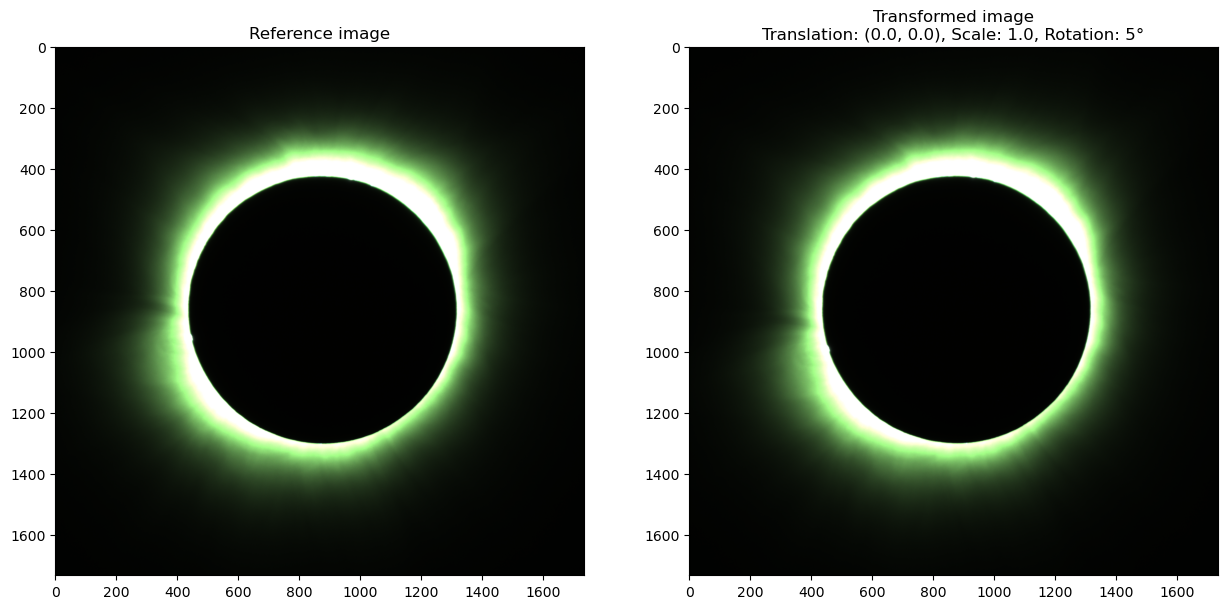

In [35]:
translate_x, translate_y = 0.0, 0.0
scale = 1.0
rotation_degrees = 5

transformed_image = transform_image(orig_image, translate_x, translate_y, scale, rotation_degrees)

crop_margin = 700

ref_image = orig_image[crop_margin:-crop_margin, crop_margin:-crop_margin, :]
transformed_image = transformed_image[crop_margin:-crop_margin, crop_margin:-crop_margin, :]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ref_image)
_ = ax[0].set_title('Reference image')
ax[1].imshow(transformed_image)
_ = ax[1].set_title('Transformed image\n'
                f'Translation: ({translate_x}, {translate_y}), '
                f'Scale: {scale}, Rotation: {rotation_degrees}°')


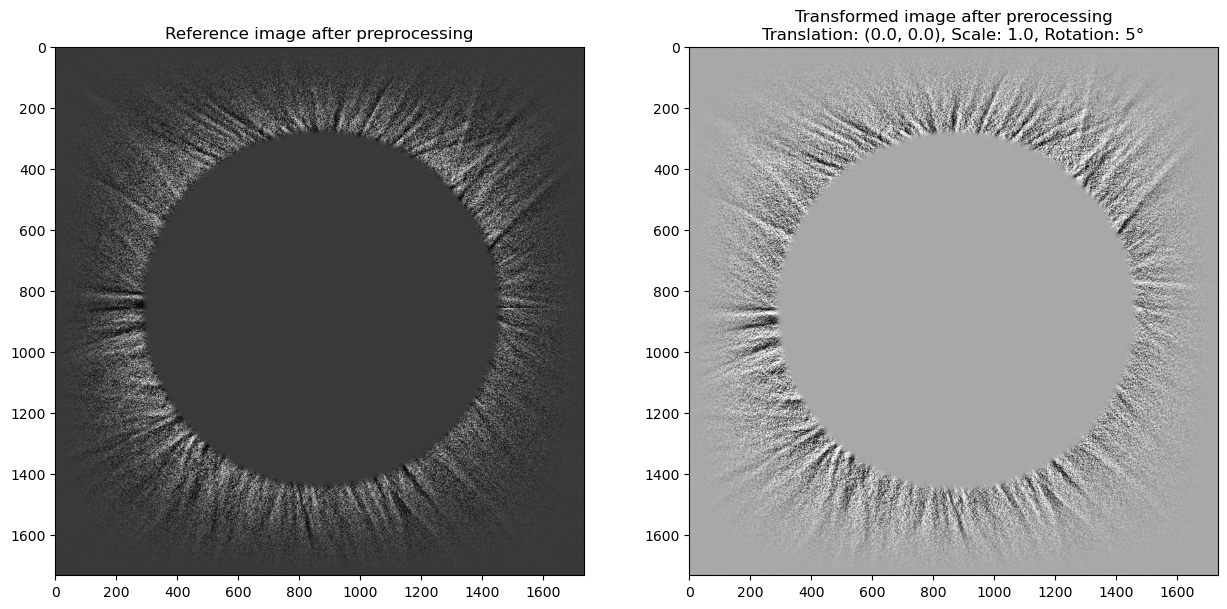

In [36]:
import sys, os
sys.path.append(os.path.abspath('..'))

from eclipsetools import preprocessing
ref_image_preproc = preprocessing.preprocess_for_alignment(ref_image)
image_preproc = preprocessing.preprocess_for_alignment(transformed_image)

def normalize_image(image):
    """Stretch image to [0, 1] range."""
    return (image - np.min(image)) / (np.max(image) - np.min(image))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(normalize_image(ref_image_preproc), cmap='gray', vmin=0.45, vmax=0.55)
_ = ax[0].set_title('Reference image after preprocessing')
ax[1].imshow(normalize_image(image_preproc), cmap='gray', vmin=0.45, vmax=0.55)
_ = ax[1].set_title('Transformed image after prerocessing\n'
                    f'Translation: ({translate_x}, {translate_y}), '
                    f'Scale: {scale}, Rotation: {rotation_degrees}°')


Next we will convert the images to the frequency domain using Fast Fourier Transform. The amplitude spectra of the images can then be treated as regular images, which will be converted to log-polar coordinates to determine rotation and scale. The frequency domain is invariant to translation, unlike the spatial domain.

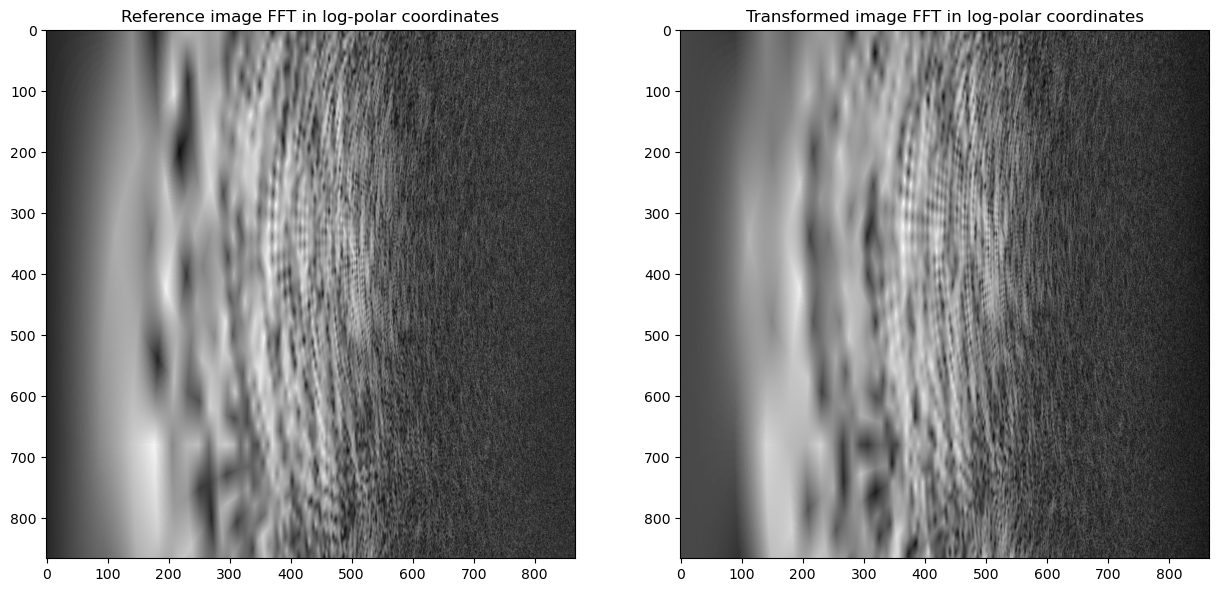

In [ ]:
def log_polar_fft(image, radius):
    assert len(image.shape) == 2, "Input image must be a 2D array (grayscale image)."
    fft_mag = np.abs(np.fft.fftshift(np.fft.fft2(image)))
    # Amplitude spectra have very high values in the low frequencies, so we use logarithm to compress the range
    fft_mag = np.log(1.0 + fft_mag)
    log_polar = cv2.warpPolar(
        src=fft_mag,
        dsize=(0, 0),
        center=(fft_mag.shape[1] // 2, fft_mag.shape[0] // 2),
        maxRadius=radius,
        flags=cv2.INTER_LINEAR | cv2.WARP_POLAR_LOG)
    return log_polar

shape = ref_image_preproc.shape
shortest_side = np.min(shape)
radius = shortest_side // 2

# We only need half of the log-polar FFTs, as they are symmetric
ref_fft_log_polar = log_polar_fft(ref_image_preproc, radius)[:shape[0] // 2, :]
image_fft_log_polar = log_polar_fft(image_preproc, radius)[:shape[0] // 2, :]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(ref_fft_log_polar, cmap='gray')
_ = ax[0].set_title('Reference image FFT in log-polar coordinates')
ax[1].imshow(image_fft_log_polar, cmap='gray')
_ = ax[1].set_title('Transformed image FFT in log-polar coordinates')

To determine rotation and scale from the frequency domain images, we use phase correlation to detect horizontal and vertical shift between the amplitude spectra. Vertical shift corresponds to rotation and horizontal shift to scaling.

In [47]:
def simple_phase_correlate(img_a, img_b, window):
    """Perform phase correlation between two images using a window."""
    assert img_a.shape == img_b.shape, "Input images must have the same shape."
    
    # Compute FFTs
    fft_a = np.fft.fft2(img_a * window)
    fft_b = np.fft.fft2(img_b * window)

    # Compute cross-power spectrum
    cross_power_spectrum = (fft_a * np.conj(fft_b)) / (np.abs(fft_a * np.conj(fft_b)) + 1e-8)

    # Inverse FFT to get the correlation
    correlation = np.abs(np.fft.ifft2(cross_power_spectrum))

    # Find peak coordinates in the correlation
    shift_y, shift_x = np.unravel_index(np.argmax(correlation), correlation.shape)

    # Shifts peak coordinates to wrap around
    if shift_x > correlation.shape[1] // 2:
        shift_x -= correlation.shape[1]

    if shift_y > correlation.shape[0] // 2:
        shift_y -= correlation.shape[0]

    return (shift_y, shift_x)

hann_window_log_polar = cv2.createHanningWindow(ref_fft_log_polar.shape[::-1], cv2.CV_32F)
shift_y, shift_x = simple_phase_correlate(ref_fft_log_polar, image_fft_log_polar, hann_window_log_polar)
print(f'Detected shift coordinates: ({shift_y}, {shift_x})')

recovered_rotation_degrees = 360.0 / np.pi * shift_y / ref_fft_log_polar.shape[0]
print(f'Detected rotation: {recovered_rotation_degrees} degrees, expected: {rotation_degrees} degrees')

# Recover scale from the correlation result
klog = np.min(ref_fft_log_polar.shape) / np.log(radius)
recovered_scale = np.exp(shift_x / klog)
print(f'Detected scale: {recovered_scale}, expected: {scale}')


Detected shift coordinates: (38, 0)
Detected rotation: 5.0282670242427905 degrees, expected: 5 degrees
Detected scale: 1.0, expected: 1.0


Now we undo the rotation and scaling with an affine transform, and use phase correlation to find the remaining translation between the original image and the new one.

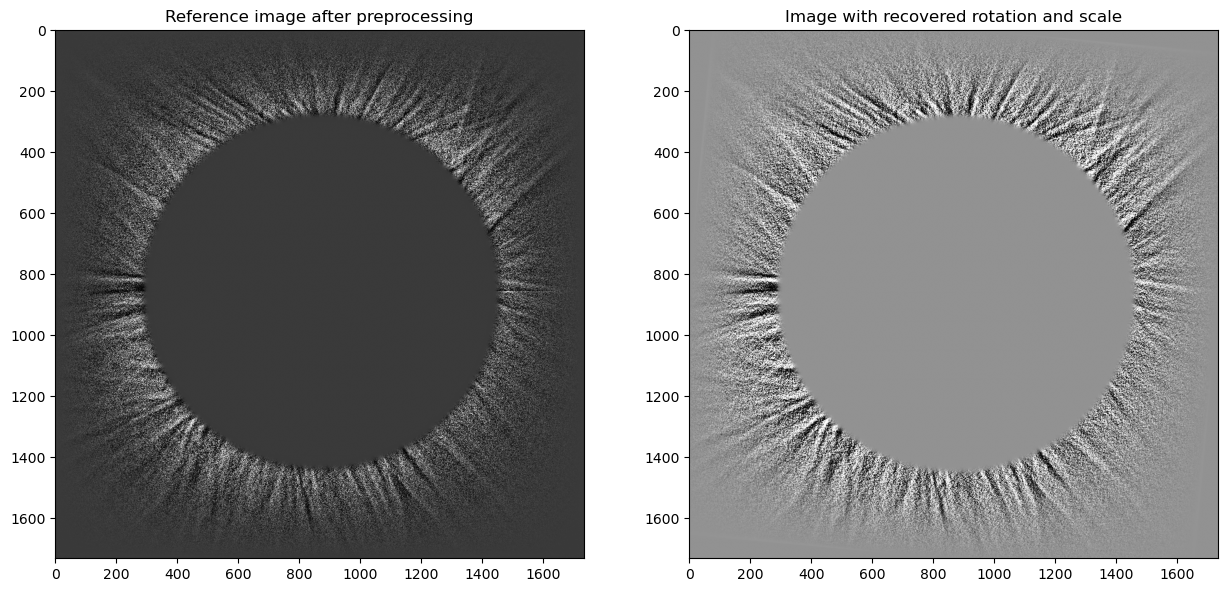

In [48]:
undo_transform_matrix = cv2.getRotationMatrix2D(
    center=(ref_image.shape[1] // 2, ref_image.shape[0] // 2),
    angle=-recovered_rotation_degrees,
    scale=1.0 / recovered_scale)

image_with_translation = cv2.warpAffine(image_preproc, 
                                        undo_transform_matrix,
                                        dsize=(ref_image.shape[1], ref_image.shape[0]),
                                        flags=cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT,
                                        borderValue=[0.0, 0.0, 0.0]).astype(np.float32)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(normalize_image(ref_image_preproc), cmap='gray', vmin=0.45, vmax=0.55)
_ = ax[0].set_title('Reference image after preprocessing')
ax[1].imshow(normalize_image(image_with_translation), cmap='gray', vmin=0.45, vmax=0.55)
_ = ax[1].set_title('Image with recovered rotation and scale')

In [49]:
hann_window = cv2.createHanningWindow(ref_image_preproc.shape[::-1], cv2.CV_32F)
translation_shift_y, translation_shift_x = simple_phase_correlate(ref_image_preproc, image_with_translation, hann_window)
print(f'Detected translation coordinates: ({-translation_shift_y}, {-translation_shift_x})')
print(f'Expected translation: ({translate_y}, {translate_x})')

Detected translation coordinates: (0, 0)
Expected translation: (0.0, 0.0)
